In [96]:
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt
seq_dim=(6,6)

(array([552., 229., 118.,  55.,  28.,  10.,   4.,   2.,   1.,   1.]),
 array([3.72155561e-05, 7.98165197e-01, 1.59629318e+00, 2.39442116e+00,
        3.19254914e+00, 3.99067712e+00, 4.78880510e+00, 5.58693309e+00,
        6.38506107e+00, 7.18318905e+00, 7.98131703e+00]),
 <BarContainer object of 10 artists>)

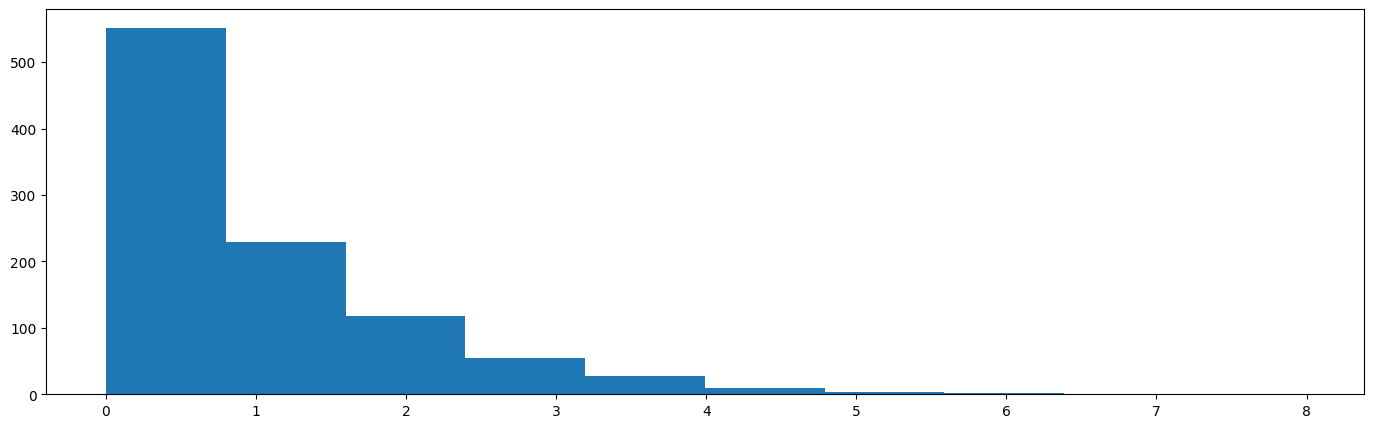

In [97]:
d = scipy.stats.expon().rvs(size=1000)
plt.hist(d)

In [98]:
import torch
import seaborn as sns
from torch.autograd import grad as torchgrad

In [99]:

def HMCwithAccept(energy,x,length,steps,epsilon):
    shape = [i if no==0 else 1 for no,i in enumerate(x.shape)]
    def grad(z):
        return torchgrad(energy(z),z,grad_outputs=z.new_ones(z.shape[0]))[0]

    torch.set_grad_enabled(False)
    E = energy(x)
    torch.set_grad_enabled(True)
    g = grad(x.requires_grad_())
    torch.set_grad_enabled(False)
    g = g.detach()
    for l in range(length):
        p = x.new_empty(size=x.size()).normal_()
        H = ((0.5*p*p).reshape(p.shape[0], -1).sum(dim=1) + E)
        xnew = x
        gnew = g
        for _ in range(steps):
            p = p- epsilon* gnew/2.
            xnew = (xnew + epsilon * p)
            torch.set_grad_enabled(True)
            gnew = grad(xnew.requires_grad_())
            torch.set_grad_enabled(False)
            xnew = xnew.detach()
            gnew = gnew.detach()
            p = p- epsilon* gnew/2.
        Enew = energy(xnew)
        Hnew = (0.5*p*p).reshape(p.shape[0], -1).sum(dim=1) + Enew
        diff = H-Hnew
        accept = (diff.exp() >= diff.uniform_()).to(x)

        E = accept*Enew + (1.-accept)*E
        acceptMask = accept.reshape(shape)
        x = acceptMask*xnew + (1.-acceptMask)*x
        g = acceptMask*gnew + (1.-acceptMask)*g
    torch.set_grad_enabled(True)

    return x, accept

def HMC(*args,**kwargs):
    x, _ = HMCwithAccept(*args,**kwargs)
    return x

class Lattice:
    def __init__(self,L, d, BC='periodic'):
        self.L = L 
        self.d = d
        self.shape = [L]*d 
        self.Nsite = L**d 
        self.BC = BC

    def move(self, idx, d, shift):
        coord = self.index2coord(idx)
        coord[d] += shift

        if self.BC != 'periodic':
            if (coord[d]>=self.L) or (coord[d]<0):
                return None
        #wrap around because of the PBC
        if (coord[d]>=self.L): coord[d] -= self.L; 
        if (coord[d]<0): coord[d] += self.L; 

        return self.coord2index(coord)

    def index2coord(self, idx):
        coord = np.zeros(self.d, int) 
        for d in range(self.d):
            coord[self.d-d-1] = idx%self.L;
            idx /= self.L
        return coord 

    def coord2index(self, coord):
        idx = coord[0]
        for d in range(1, self.d):
            idx *= self.L; 
            idx += coord[d]
        return idx 

class Hypercube(Lattice):
    def __init__(self,L, d, BC='periodic'):
        super(Hypercube, self).__init__(L, d, BC)
        self.Adj = np.zeros((self.Nsite,self.Nsite), int)
        for i in range(self.Nsite):
            for d in range(self.d):
                j = self.move(i, d, 1)

                if j is not None:
                    self.Adj[i, j] = 1.0
                    self.Adj[j, i] = 1.0

from scipy.linalg import eigh, inv, det 
import math
class Ising:
    def __init__(self,L,d,beta,name = None):
        if name is None:
            name = "Ising_l"+str(L)+"_d" +str(d)+"_beta"+str(beta)
        self.beta = beta
        self.lattice = Hypercube(L, d, 'periodic')
        self.K = self.lattice.Adj*beta
    
        w, v = eigh(self.K)    
        offset = 0.1-w.min()
        print("offset", offset)
        self.K += np.eye(w.size)*offset
        sign, logdet = np.linalg.slogdet(self.K)
        #print (sign)
        #print (0.5*self.nvars[0] *(np.log(4.)-offset - np.log(2.*np.pi)) - 0.5*logdet)
        self.Kinv = torch.from_numpy(inv(self.K)).to(torch.float32)
        self.nvars = [L**d]

    def energy(self,x):
        return -(-0.5*(torch.mm(x.reshape(-1, self.nvars[0]),self.Kinv) * x.reshape(-1, self.nvars[0])).sum(dim=1) \
        + (torch.nn.Softplus()(2.*x.reshape(-1, self.nvars[0])) - x.reshape(-1, self.nvars[0]) - math.log(2.)).sum(dim=1))

    def var_energy_beta(self,x, beta_new):
        return self.energy(x)*(beta_new-self.beta)/self.beta

    def lnZ(self,x,beta_here=None):
        e = self.energy(x)
        if beta_here is None:
            beta_here = self.beta
        Z_here = (torch.exp(-e/self.beta*beta_here)).sum()
        return torch.log(Z_here)

    '''
    def atomic_energy(self,x):
        return -(-0.5*(torch.mm(x.reshape(-1, self.nvars[0]),self.Kinv) * x.reshape(-1, self.nvars[0])) \
        + (torch.nn.Softplus()(2.*x.reshape(-1, self.nvars[0])) - x.reshape(-1, self.nvars[0]) - math.log(2.)))

    def jac_atomic_energy(self,x):
        # atomic_e = self.atomic_energy(x)
        B = x.shape[0]
        u = torch.zeros([B,self.nvars[0],self.nvars[0]])
        for ii in range(self.nvars[0]):
            # for jj in range(self.nvars[0]):
                u[:,ii,:] += 0.5*(torch.mm(x.reshape(-1, self.nvars[0]),self.Kinv)) 
                u[:,ii,ii] += -( 2.*(1-torch.nn.Sigmoid()(-2.*x.reshape(-1, self.nvars[0])[:,ii])) - 1.)
        return u
    
    def jac_energy(self,x):
        jac_atomic_e = self.jac_atomic_energy(x)
        return jac_atomic_e.sum(dim=1)
    '''

    def sample(self, batchSize, thermalSteps = 50, interSteps=5, epsilon=0.1, initial = None):
        return self._sampleWithHMC(batchSize,thermalSteps,interSteps, epsilon, initial)


    def _sampleWithHMC(self,batchSize,thermalSteps = 50, interSteps = 5, epsilon=0.1, initial = None):
        if initial is None:
            initial = torch.randn([batchSize]+self.nvars,requires_grad=True)
        initial = HMC(self.energy,initial,thermalSteps,interSteps,epsilon)
        return initial.detach()



In [100]:
import torch.autograd as autograd

def grad(energy, z):
    return torchgrad(energy(z),z,grad_outputs=z.new_ones(z.shape[0]))[0]


In [144]:

def DiffusionwithDrift(energy,lnZ,x,length,epsilon,decay=0.9):
    shape = [i if no==0 else 1 for no,i in enumerate(x.shape)]
    def grad(z):
        return torchgrad(energy(z),z,grad_outputs=z.new_ones(z.shape[0]))[0]
    epsilon = torch.tensor(epsilon)
    epsilon.requires_grad_(False)

    g = -grad(x.requires_grad_())*(torch.exp(-energy(x))/torch.exp(lnZ(x)))[:,None]

    g = g.detach()
    x = x.detach()
    x_t = []
    x_t.append(x)
    '''
    plt.figure(figsize=(17,5))
    plt.subplot(131)
    _ = plt.hist2d(x.reshape(-1,36)[:,0], x.reshape(-1,36)[:,1], bins=100)
    plt.colorbar()
    plt.subplot(132)
    _ = plt.hist(x.reshape(-1,36).sum(-1), bins=100, edgecolor='black', histtype='step', label="x")
    _ = plt.hist(g.reshape(-1,36).sum(-1), bins=100, edgecolor='red', histtype='step', label="$Grad_x(P)$")
    plt.legend()
    plt.subplot(133)
    _ = plt.scatter(x.reshape(-1), g.reshape(-1), s=5)
    plt.xlabel("x")
    plt.ylabel("$Grad_x(P)$")
    '''

    for l in range(1, length+1):
        z = torch.normal(0,1,size=x.size())
        x = x + 0.5 * epsilon * g + epsilon.sqrt() * z
        # x = x + 0.5 * epsilon * g
        g = -grad(x.requires_grad_())*(torch.exp(-energy(x))/torch.exp(lnZ(x)))[:,None]
        x = x.detach()
        g = g.detach()
        epsilon*=decay
        
        '''
        if l %5 == 0:
            plt.figure(figsize=(17,5))
            plt.subplot(131)
            _ = plt.hist2d(x.reshape(-1,36)[:,0], x.reshape(-1,36)[:,1], bins=100)
            plt.colorbar()
            plt.subplot(132)
            _ = plt.hist(x.reshape(-1,36).sum(-1), bins=100, edgecolor='black', histtype='step', label="x")
            _ = plt.hist(g.reshape(-1,36).sum(-1), bins=100, edgecolor='red', histtype='step', label="$Grad_x(P)$")
            plt.legend()
            plt.subplot(133)
            _ = plt.scatter(x.reshape(-1), g.reshape(-1), s=5)
            plt.xlabel("x")
            plt.ylabel("$Grad_x(P)$")
        '''
        x_t.append(x)
    return x_t


In [ ]:

def DiffusionMap(energy, xx):
    dmat = 
    return 


# Diffusion
- Start distribution: N(0,1)
- End distribution: $k_BT=10J$

offset 0.4999999999999998


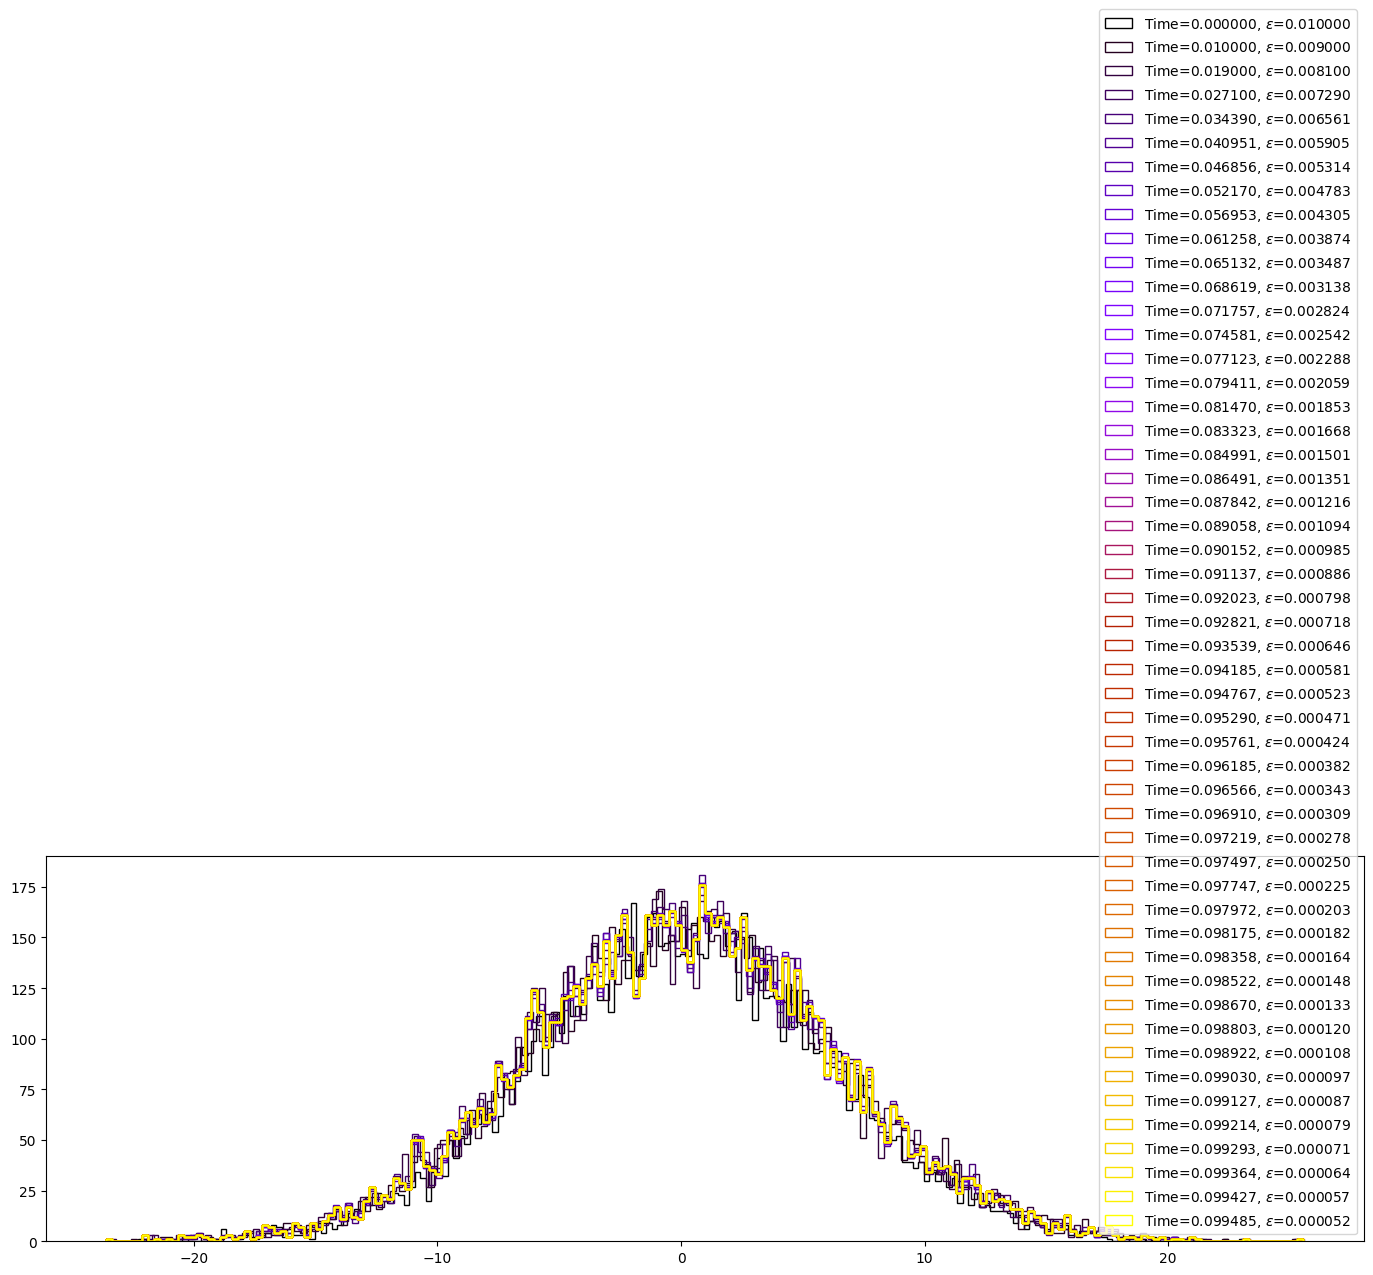

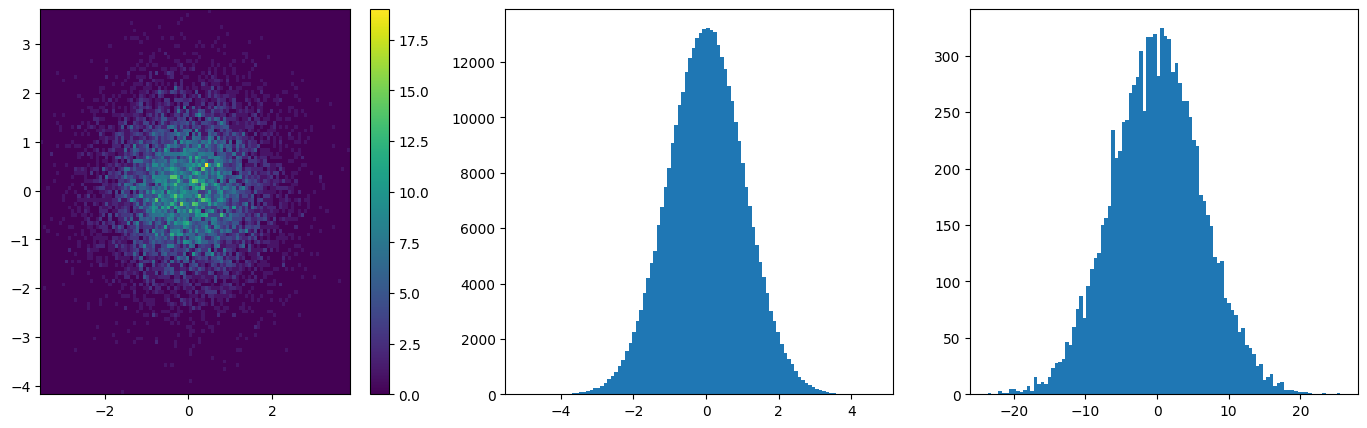

In [146]:
ising = Ising(6,2,0.1)
initial = torch.randn([10000]+ising.nvars,requires_grad=True)
thermolength = 1000
epsilon = 0.01
x_t = DiffusionwithDrift(ising.energy, ising.lnZ, initial, thermolength, epsilon)

line_color = [plt.colormaps["gnuplot"](float(i)/float(thermolength+1)) for i in range(thermolength+1)]
plt.figure()
epsilon = 0.01
t=0
for i in range(0, len(x_t), 20):
    plt.hist(x_t[i].reshape(-1,36).sum(-1), bins=200, edgecolor=line_color[i], histtype='step', label="Time=%f, $\epsilon$=%f"%(t,epsilon))
    t+=epsilon
    epsilon*=0.9
plt.legend()

xx = x_t[-1]
plt.figure(figsize=(17, 5))
plt.subplot(131)
_ = plt.hist2d(xx.reshape(-1,36)[:,0], xx.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx.reshape(-1,36).sum(-1), bins=100)


# Diffusion
- Start distribution: $k_BT=10J$
- End distribution: $k_BT=5J$

offset 0.8999999999999996


Text(0.5, 0, 'Magnetization')

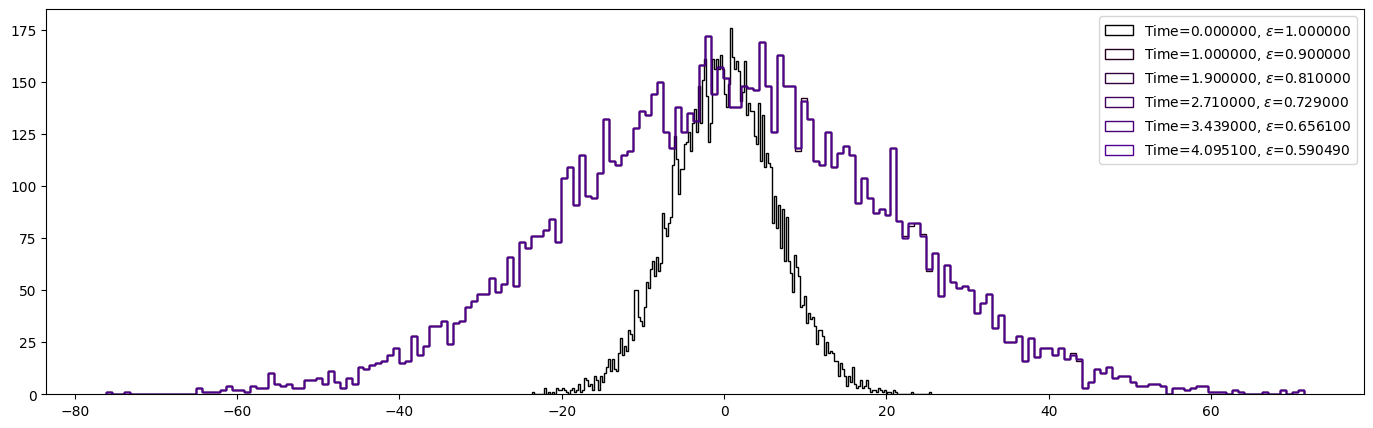

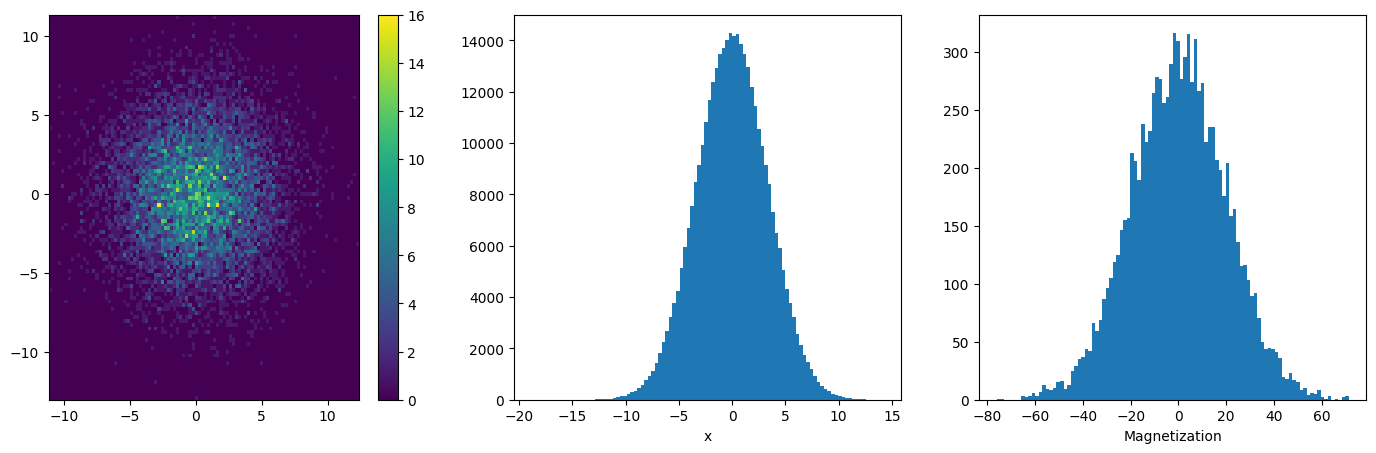

In [150]:
ising = Ising(6,2,0.2)
thermolength = 10000
epsilon = 1.
initial = x_t[-1]
x_t_1 = DiffusionwithDrift(ising.energy, ising.lnZ, initial, thermolength, epsilon)

line_color = [plt.colormaps["gnuplot"](float(i)/float(thermolength+1)) for i in range(thermolength+1)]
plt.figure()
epsilon = 1.
t=0
for i in range(0, len(x_t), 200):
    plt.hist(x_t_1[i].reshape(-1,36).sum(-1), bins=200, edgecolor=line_color[i], histtype='step', label="Time=%f, $\epsilon$=%f"%(t,epsilon))
    t+=epsilon
    epsilon*=0.9
plt.legend()

xx = x_t_1[-1]
plt.figure(figsize=(17, 5))
plt.subplot(131)
_ = plt.hist2d(xx.reshape(-1,36)[:,0], xx.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx.reshape(-1), bins=100)
plt.xlabel("x")
plt.subplot(133)
_ = plt.hist(xx.reshape(-1,36).sum(-1), bins=100)
plt.xlabel("Magnetization")

In [ ]:
raise RuntimeError

# Test the gaussian integral continuous Ising model
## Sample by annealing
$k_BT=10J\rightarrow 5J\rightarrow 4J\rightarrow 2.5J$

offset 0.4999999999999998


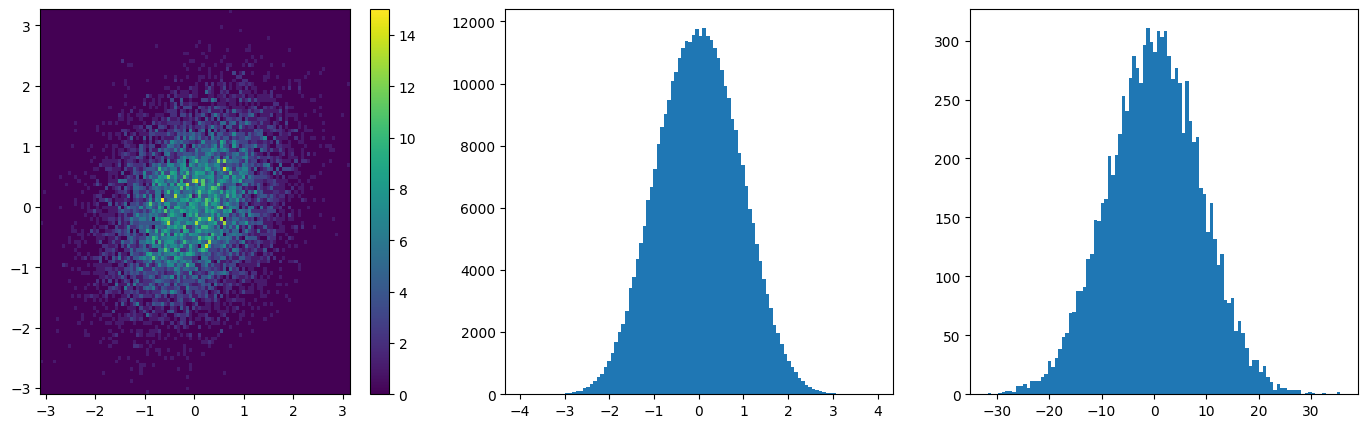

In [128]:
# B=2**15
# H=6
# W=6
# xx = torch.concat([torch.normal(0.0001, 2, size=(int(B/2),H,W)), torch.normal(-0.0001, 2, size=(int(B/2),H,W))], dim=0)

# ising = Ising(6,2,1.1)
# xx = ising.sample(1000)
# plt.figure()
# plt.subplot(121)
# plt.hist(xx.reshape(-1), bins=100)
# plt.subplot(122)
# plt.hist(xx.reshape(-1,36).sum(-1), bins=100)
plt.rcParams['figure.figsize'] = (17, 5)
ising = Ising(6,2,0.1)
xx0 = ising.sample(10000)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx0.reshape(-1,36)[:,0], xx0.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx0.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx0.reshape(-1,36).sum(-1), bins=100)

offset 0.8999999999999996


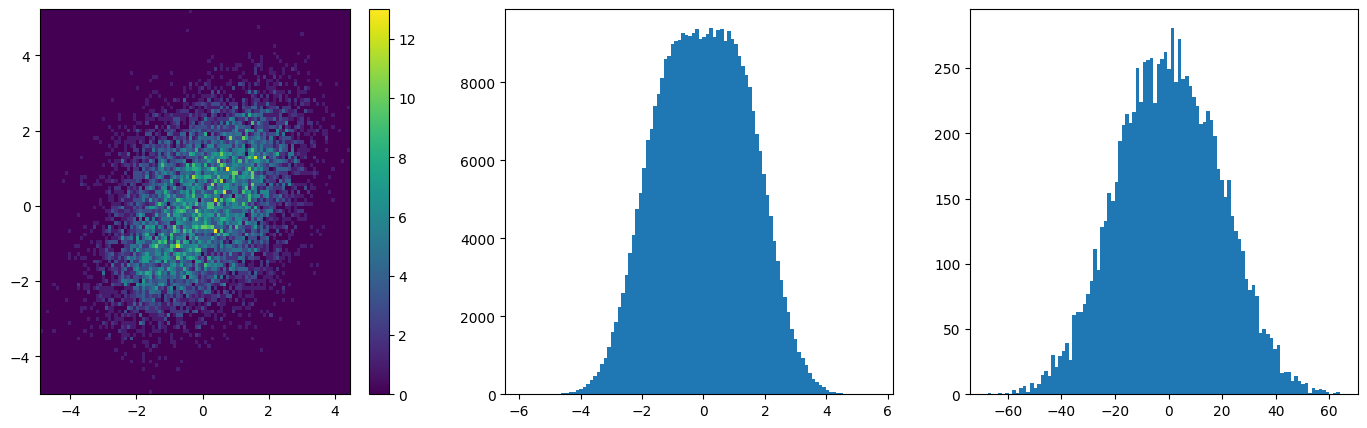

In [130]:
ising = Ising(6,2,0.2)
xx1 = ising.sample(1000, thermalSteps = 1000, interSteps=50, initial=xx0)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx1.reshape(-1,36)[:,0], xx1.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx1.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx1.reshape(-1,36).sum(-1), bins=100)

offset 1.0999999999999988


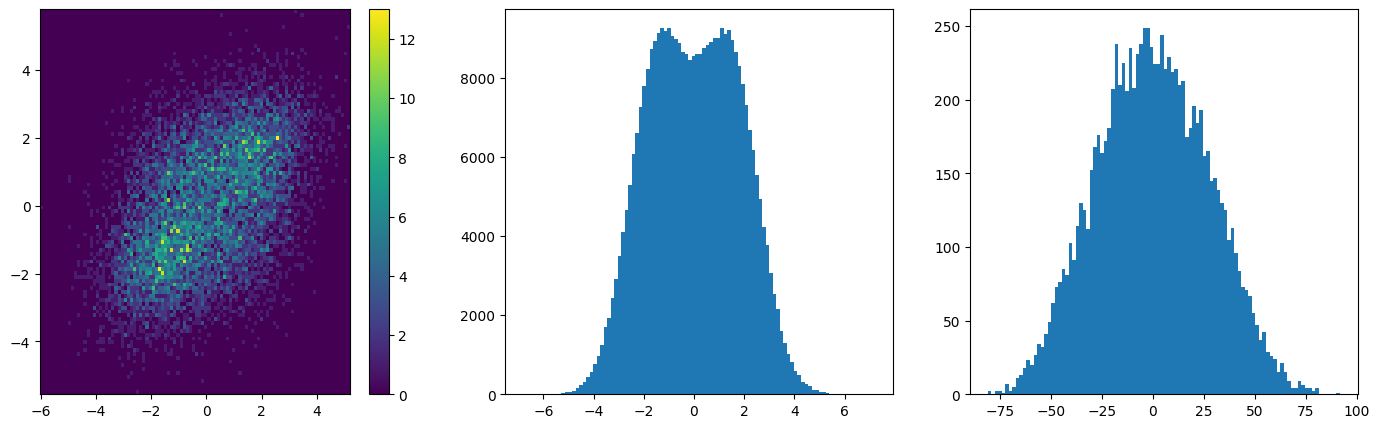

In [131]:
ising = Ising(6,2,0.25)
xx2 = ising.sample(1000, thermalSteps = 1000, interSteps=50, initial=xx1)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx2.reshape(-1,36)[:,0], xx2.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx2.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx2.reshape(-1,36).sum(-1), bins=100)

offset 1.6999999999999993


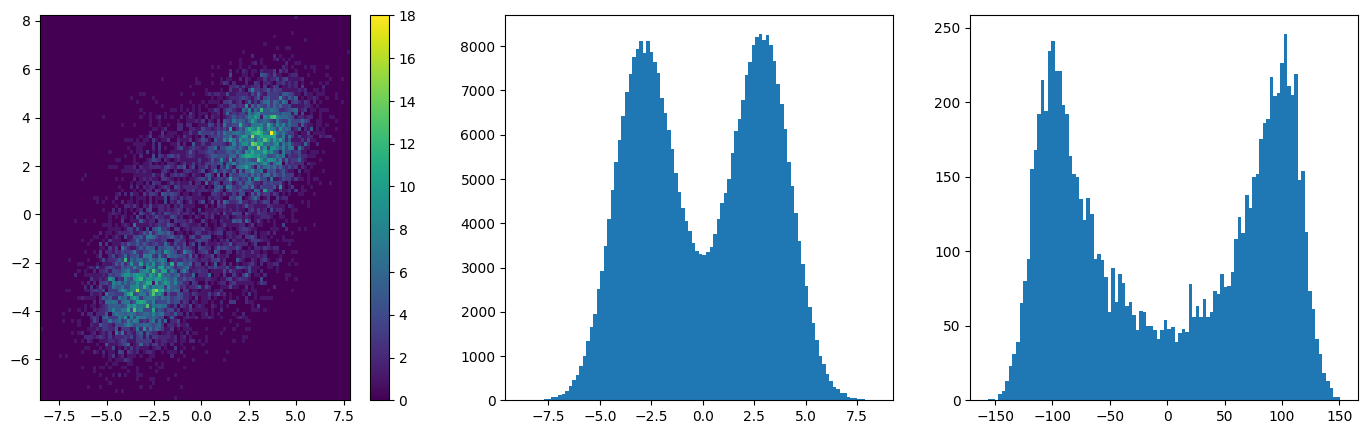

In [132]:
ising = Ising(6,2,0.4)
xx3 = ising.sample(1000, thermalSteps = 1000, interSteps=50, initial=xx2)
plt.figure()
plt.subplot(131)
_ = plt.hist2d(xx3.reshape(-1,36)[:,0], xx3.reshape(-1,36)[:,1], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist(xx3.reshape(-1), bins=100)
plt.subplot(133)
_ = plt.hist(xx3.reshape(-1,36).sum(-1), bins=100)

# Auxiliary force to implement temperature change:
$F(\beta \rightarrow \beta+\delta \beta)=-\nabla U*\delta \beta$

In [ ]:

def HMCwithAccept_Tdrift(energy,x,length,steps,epsilon):
    shape = [i if no==0 else 1 for no,i in enumerate(x.shape)]
    def grad(z):
        return torchgrad(energy(z),z,grad_outputs=z.new_ones(z.shape[0]))[0]

    torch.set_grad_enabled(False)
    E = energy(x)
    torch.set_grad_enabled(True)
    g = grad(x.requires_grad_())
    torch.set_grad_enabled(False)
    g = g.detach()
    for l in range(length):
        p = x.new_empty(size=x.size()).normal_()
        H = ((0.5*p*p).reshape(p.shape[0], -1).sum(dim=1) + E)
        xnew = x
        gnew = g
        for _ in range(steps):
            p = p- epsilon* gnew/2.
            xnew = (xnew + epsilon * p)
            torch.set_grad_enabled(True)
            gnew = grad(xnew.requires_grad_())
            torch.set_grad_enabled(False)
            xnew = xnew.detach()
            gnew = gnew.detach()
            p = p- epsilon* gnew/2.
        Enew = energy(xnew)
        Hnew = (0.5*p*p).reshape(p.shape[0], -1).sum(dim=1) + Enew
        diff = H-Hnew
        accept = (diff.exp() >= diff.uniform_()).to(x)

        E = accept*Enew + (1.-accept)*E
        acceptMask = accept.reshape(shape)
        x = acceptMask*xnew + (1.-acceptMask)*x
        g = acceptMask*gnew + (1.-acceptMask)*g
    torch.set_grad_enabled(True)

    return x, accept
